<a href="https://colab.research.google.com/github/aovaldes2/-Data-Science-Portfolio/blob/main/Forest_Cover_Type_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing and importing dependencies

In [ ]:
  #dependency installs
  !pip install kaggle

In [ ]:
# import dependencies
import numpy as np 
import pandas as pd
import io
import time
import math
from scipy import stats
from datetime import date

# for visualization
from IPython.core.pylabtools import figsize
from matplotlib import pyplot as plt
%matplotlib inline
# to include graphs inline within the frontends next to code
import seaborn as sns


# machine learning models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# preprocessing functions and evaluation models
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

# settings
import warnings
warnings.filterwarnings("ignore")

# Google drive conection

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Checking MyDrive Folder

In [ ]:
import os.path
from os import path

if path.exists('/content/gdrive/MyDrive/Forest Cover Type Prediction') == False:
  os.mkdir('/content/gdrive/MyDrive/Forest Cover Type Prediction')

os.chdir('/content/gdrive/MyDrive/Forest Cover Type Prediction')
!pwd
!ls

/content/gdrive/MyDrive/Forest Cover Type Prediction
baseline_submission.csv       sampleSubmission.csv	test.csv.zip
ExtraTreeRand_submission.csv  sampleSubmission.csv.zip	train.csv
kaggle.json		      test3.csv			train.csv.zip
LGBMRand_submission.csv       test.csv


## Upload  the kaggle credentials(Needed only the first time)

In [ ]:
#upload  the kaggle credentials
if path.exists('/content/gdrive/MyDrive/Forest Cover Type Prediction/kaggle.json') == False:
  from google.colab import files
  files.upload()

%ls

baseline_submission.csv       sampleSubmission.csv      test.csv.zip
ExtraTreeRand_submission.csv  sampleSubmission.csv.zip  train.csv
kaggle.json                   test3.csv                 train.csv.zip
LGBMRand_submission.csv       test.csv


# Download the dataset from Kaggle

In [ ]:
#Download the dataset
Subpath = '/content/gdrive/MyDrive/Forest Cover Type Prediction/'

if path.exists(Subpath+'sampleSubmission.csv.zip') == False:
  !kaggle competitions download -c forest-cover-type-prediction  


#Unzip Data
Subpath = '/content/gdrive/MyDrive/Forest Cover Type Prediction/'
if path.exists(Subpath+'test.csv') == False:
  !unzip test.csv.zip
if path.exists(Subpath+'train.csv') == False:  
  !unzip train.csv.zip
if path.exists(Subpath+'sampleSubmission.csv') == False:
  !unzip sampleSubmission.csv.zip


# Defining the datasets

In [ ]:
df_train = pd.read_csv(Subpath+'train.csv')
df_test = pd.read_csv(Subpath+'test.csv')
df_test3 = pd.read_csv(Subpath+'test3.csv')



### Useful functions



In [ ]:
# function to train a given model, generate predictions, and return accuracy score
def fit_evaluate_model(model, X_train, y_train, X_valid, Y_valid):
    model.fit(X_train, y_train)
    y_predicted = model.predict(X_valid)
    return accuracy_score(y_valid, y_predicted)

In [ ]:
def unistats(df):
    import pandas as pd
    output_df = pd.DataFrame(columns=['Count','Missing','Unique','Dtype','Numeric','Mode','Mean','Min','25%','Median','75%','Max','Std','Skew','Kurt'])
    for col in df:
        if pd.api.types.is_numeric_dtype(df[col]) and df[col].dtype !='bool' and pd.isnull(df[col]).all()!=True:
            
            output_df.loc[col] = [df[col].count(), df[col].isnull().sum(), df[col].nunique(), df[col].dtype,pd.api.types.is_numeric_dtype(df[col]),
                                  df[col].mode().values[0], df[col].mean(),df[col].min(), df[col].quantile(0.25), df[col].median(),
                                  df[col].quantile(0.75), df[col].max(), df[col].std(), df[col].skew(), df[col].kurt()]
        else:
            output_df.loc[col] = [df[col].count(), df[col].isnull().sum(), df[col].nunique(), df[col].dtype,pd.api.types.is_numeric_dtype(df[col]),
                                   '-' if pd.isnull(df[col]).all() else df[col].mode().values[0],'-','-','-','-','-','-','-','-','-']
    return output_df.sort_values(by=['Numeric', 'Skew','Unique'],ascending=False)

# **Exploratory Data Analysis**

In [ ]:
df_train

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,1,2596,51,3,258,0,510,221,232,148,6279,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
1,2,2590,56,2,212,-6,390,220,235,151,6225,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
2,3,2804,139,9,268,65,3180,234,238,135,6121,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
3,4,2785,155,18,242,118,3090,238,238,122,6211,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2
4,5,2595,45,2,153,-1,391,220,234,150,6172,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15115,15116,2607,243,23,258,7,660,170,251,214,1282,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
15116,15117,2603,121,19,633,195,618,249,221,91,1325,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
15117,15118,2492,134,25,365,117,335,250,220,83,1187,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
15118,15119,2487,167,28,218,101,242,229,237,119,932,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3


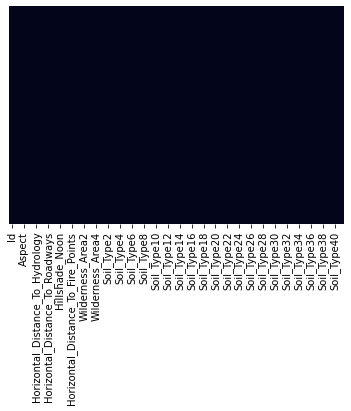

In [ ]:
#No missing values
import seaborn as sns
sns.heatmap(df_train.isnull(),yticklabels=False,cbar=False);

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15120 entries, 0 to 15119
Data columns (total 56 columns):
 #   Column                              Non-Null Count  Dtype
---  ------                              --------------  -----
 0   Id                                  15120 non-null  int64
 1   Elevation                           15120 non-null  int64
 2   Aspect                              15120 non-null  int64
 3   Slope                               15120 non-null  int64
 4   Horizontal_Distance_To_Hydrology    15120 non-null  int64
 5   Vertical_Distance_To_Hydrology      15120 non-null  int64
 6   Horizontal_Distance_To_Roadways     15120 non-null  int64
 7   Hillshade_9am                       15120 non-null  int64
 8   Hillshade_Noon                      15120 non-null  int64
 9   Hillshade_3pm                       15120 non-null  int64
 10  Horizontal_Distance_To_Fire_Points  15120 non-null  int64
 11  Wilderness_Area1                    15120 non-null  int64
 12  Wild

In [ ]:
base_features = df_train.columns[1:56]
base_features

Index(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
       'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10',
       'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14',
       'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18',
       'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22',
       'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26',
       'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30',
       'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34',
       'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38',
       'Soil_Type39', 'Soil_Type40

In [ ]:
#The data is balanced
#sns.countplot(x='Cover_Type', data=df_train);
df_train.groupby(['Cover_Type']).agg(['count'])['Id']


,count
Cover_Type,
1,2160
2,2160
3,2160
4,2160
5,2160
6,2160
7,2160


## Data Fields 



***Elevation*** - Elevation in meters

***Aspect*** - Aspect in degrees azimuth

***Slope*** - Slope in degrees

***Horizontal_Distance_To_Hydrology*** - Horz Dist to nearest surface water features

***Vertical_Distance_To_Hydrology*** - Vert Dist to nearest surface water features

***Horizontal_Distance_To_Roadways*** - Horz Dist to nearest roadway

***Hillshade_9am*** (0 to 255 index) - Hillshade index at 9am, summer solstice

***Hillshade_Noon*** (0 to 255 index) - Hillshade index at noon, summer solstice

***Hillshade_3pm*** (0 to 255 index) - Hillshade index at 3pm, summer solstice

***Horizontal_Distance_To_Fire_Points*** - Horz Dist to nearest wildfire ignition points

***Cover_Type*** (7 types, integers 1 to 7) - Forest Cover Type designation

***Wilderness_Area*** (4 binary columns, 0 = absence or 1 = presence) - Wilderness area designation


> The ***Wilderness_Areas*** are:
1. Rawah Wilderness Area
2. Neota Wilderness Area
3. Comanche Peak Wilderness Area
4. Cache la Poudre Wilderness Area


***Soil_Type*** (40 binary columns, 0 = absence or 1 = presence) - Soil Type designation

>The ***Soil_Type*** are:
1. Cathedral family - Rock outcrop complex, extremely stony.
2. Vanet - Ratake families complex, very stony.
3. Haploborolis - Rock outcrop complex, rubbly.
4. Ratake family - Rock outcrop complex, rubbly.
5. Vanet family - Rock outcrop complex complex, rubbly.
6. Vanet - Wetmore families - Rock outcrop complex, stony.
7. Gothic family.
8. Supervisor - Limber families complex.
9. Troutville family, very stony.
10. Bullwark - Catamount families - Rock outcrop complex, rubbly.
11. Bullwark - Catamount families - Rock land complex, rubbly.
12. Legault family - Rock land complex, stony.
13. Catamount family - Rock land - Bullwark family complex, rubbly.
14. Pachic Argiborolis - Aquolis complex.
15. unspecified in the USFS Soil and ELU Survey.
16. Cryaquolis - Cryoborolis complex.
17. Gateview family - Cryaquolis complex.
18. Rogert family, very stony.
19. Typic Cryaquolis - Borohemists complex.
20. Typic Cryaquepts - Typic Cryaquolls complex.
21. Typic Cryaquolls - Leighcan family, till substratum complex.
22. Leighcan family, till substratum, extremely bouldery.
23. Leighcan family, till substratum - Typic Cryaquolls complex.
24. Leighcan family, extremely stony.
25. Leighcan family, warm, extremely stony.
26. Granile - Catamount families complex, very stony.
27. Leighcan family, warm - Rock outcrop complex, extremely stony.
28. Leighcan family - Rock outcrop complex, extremely stony.
29. Como - Legault families complex, extremely stony.
30. Como family - Rock land - Legault family complex, extremely stony.
31. Leighcan - Catamount families complex, extremely stony.
32. Catamount family - Rock outcrop - Leighcan family complex, extremely stony.
33. Leighcan - Catamount families - Rock outcrop complex, extremely stony.
34. Cryorthents - Rock land complex, extremely stony.
35. Cryumbrepts - Rock outcrop - Cryaquepts complex.
36. Bross family - Rock land - Cryumbrepts complex, extremely stony.
37. Rock outcrop - Cryumbrepts - Cryorthents complex, extremely stony.
38. Leighcan - Moran families - Cryaquolls complex, extremely stony.
39. Moran family - Cryorthents - Leighcan family complex, extremely stony.
40. Moran family - Cryorthents - Rock land complex, extremely stony.

---



## Univariate statistics

In [ ]:
unistats(df_train)

,Count,Missing,Unique,Dtype,Numeric,Mode,Mean,Min,25%,Median,75%,Max,Std,Skew,Kurt
Soil_Type8,15120,0,2,int64,True,0,0.000066,0,0.00,0.0,0.00,1,0.008133,122.963409,15120.000000
Soil_Type25,15120,0,2,int64,True,0,0.000066,0,0.00,0.0,0.00,1,0.008133,122.963409,15120.000000
Soil_Type28,15120,0,2,int64,True,0,0.000595,0,0.00,0.0,0.00,1,0.024391,40.955261,1675.555027
Soil_Type9,15120,0,2,int64,True,0,0.000661,0,0.00,0.0,0.00,1,0.025710,38.849712,1507.499524
Soil_Type36,15120,0,2,int64,True,0,0.000661,0,0.00,0.0,0.00,1,0.025710,38.849712,1507.499524
Soil_Type27,15120,0,2,int64,True,0,0.000992,0,0.00,0.0,0.00,1,0.031482,31.704896,1003.333149
Soil_Type21,15120,0,2,int64,True,0,0.001058,0,0.00,0.0,0.00,1,0.032514,30.695081,940.312377
Soil_Type34,15120,0,2,int64,True,0,0.001455,0,0.00,0.0,0.00,1,0.038118,26.161230,682.500255
Soil_Type37,15120,0,2,int64,True,0,0.002249,0,0.00,0.0,0.00,1,0.047368,21.018939,439.853974
Soil_Type19,15120,0,2,int64,True,0,0.003042,0,0.00,0.0,0.00,1,0.055075,18.048915,323.806169


In [ ]:
#Given the data we have numeric and cathegorical variables

numeric_columns = df_train.columns[1:11].tolist()


In [ ]:
def outlier_function(df, col_name):
    ''' this function detects first and third quartile and interquartile range for a given column of a dataframe
    then calculates upper and lower limits to determine outliers conservatively
    returns the number of lower and uper limit and number of outliers respectively
    '''
    first_quartile = np.percentile(np.array(df[col_name].tolist()), 25)
    third_quartile = np.percentile(np.array(df[col_name].tolist()), 75)
    IQR = third_quartile - first_quartile
                      
    upper_limit = third_quartile+(3*IQR)
    lower_limit = first_quartile-(3*IQR)
    outlier_count = 0
                      
    for value in df[col_name].tolist():
        if (value < lower_limit) | (value > upper_limit):
            outlier_count +=1
    return lower_limit, upper_limit, outlier_count

In [ ]:
# loop through all columns to see if there are any outliers
for column in numeric_columns:
    if outlier_function(df_train, column)[2] > 0:
        print("There are {} outliers in {}".format(outlier_function(df_train, column)[2], column))

There are 53 outliers in Horizontal_Distance_To_Hydrology
There are 49 outliers in Vertical_Distance_To_Hydrology
There are 3 outliers in Horizontal_Distance_To_Roadways
There are 7 outliers in Hillshade_9am
There are 20 outliers in Hillshade_Noon
There are 132 outliers in Horizontal_Distance_To_Fire_Points


## Summary so far(understanding the data):



* Train dataset has 15120 rows and 56 columns.
* Each column has numeric (integer/float) datatype.
* There are no NA in the dataset.Thus dataset is properly formatted and balanced.
* Only 4 columns had outliers.
    1. Horizontal_Distance_To_Hydrology
    2. Vertical_Distance_To_Hydrology
    3. Horizontal_Distance_To_Roadways
    4. Horizontal_Distance_To_Fire_Points
    **I am not going to consider the Hillsahde columns for potential outlier elimination because their data range is already fixed between 0 and 255.**
* Cover_Type is our label/target column

## Bivariate statistics

Checking the non-uniform distribution that the Cover_Type variable shows among the differents Wilderness_Areas

In [ ]:
def wilderness_name(w_at):
    '''This function assign the names of the Wilderness areas'''
    names_c =['Rawah Wilderness Area',
              'Neota Wilderness Area',
              'Comanche Peak Wilderness Area',
              'Cache la Poudre Wilderness Area']
    
    for i in range(len(w_at)):
      w_at[i]=names_c[int(w_at[i][-1])-1] 

    
    return w_at  

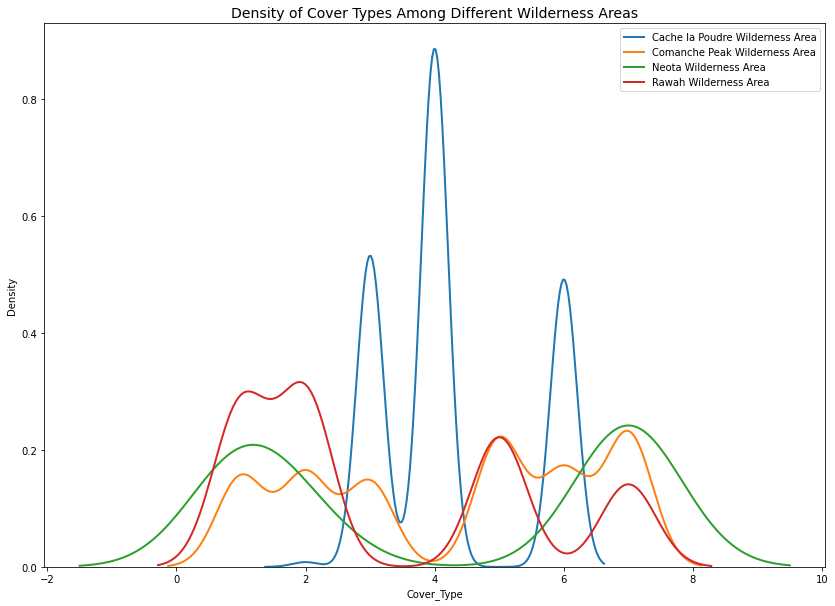

In [ ]:
# Create one column as Wilderness_Area_Type and represent it as categorical data
df_train['Wilderness_Area_Type'] = (df_train.iloc[:, 11:15] == 1).idxmax(1)

df_train['Wilderness_Area_Type'] = wilderness_name(df_train['Wilderness_Area_Type'])

#list of wilderness areas
wilderness_areas = sorted(df_train['Wilderness_Area_Type'].value_counts().index.tolist())

# distribution of the cover type in different wilderness areas
figsize(14,10)

# plot cover_type distribution for each wilderness area
for area in wilderness_areas:
    subset = df_train[df_train['Wilderness_Area_Type'] == area]
    sns.kdeplot(subset["Cover_Type"], label=area, linewidth=2)

# set title, legends and labels
plt.ylabel("Density")
plt.xlabel("Cover_Type")
plt.title("Density of Cover Types Among Different Wilderness Areas", size=14)
plt.legend();

**Wilderness area is an important feature to determine the cover type:**

* Spruce/Fir, Lodgepole Pine and Krummholz (Cover_Type 1, 2, 7) mostly found in Rawah, Neota and Comanche Peak Wilderness Area.
* It is highly likely to find Ponderosa Pine (Cover_Type 3) in Cache la Poudre Wilderness Area rather than other areas.
* Cottonwood/Willow (Cover_Type 4) seems to be found only in Cache la Poudre Wilderness Area.
* Aspen (Cover_Type 5) is equally likely to come from wilderness area Rawah and Comanche.
* Douglas-fir (Cover_Type 6) can be found in any of the wilderness areas.


**Note that, distribution of cover types extend more than the range because of the kernel density estimation.**

In [ ]:
import re
def get_trailing_number(s):
    m = re.search(r'\d+$', s)
    return int(m.group()) if m else None

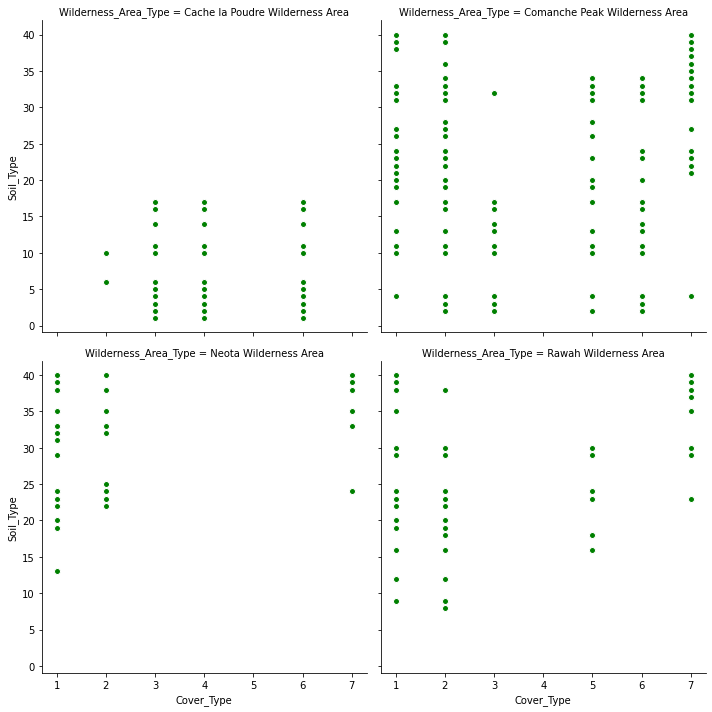

In [ ]:
df_train['Soil_Type']=(df_train.iloc[:, 15:55] == 1).idxmax(1)

for i in range(len(df_train['Soil_Type'])):
  df_train['Soil_Type'][i]=get_trailing_number (df_train['Soil_Type'][i])

# plot relationship of soil type and cover type among different wilderness areas
g = sns.FacetGrid(df_train, col="Wilderness_Area_Type", 
                  col_wrap=2, height=5, col_order=wilderness_areas)
g = g.map(plt.scatter,"Cover_Type", "Soil_Type", edgecolor="w", color="g")



* The Comanche Peak Wilderness Area (Wilderness Area 3) is the most diverse in terms of soil type and cover type.
* Only soil types 1 through 20 is represented in the Cache la Poudre Wilderness Area (Wilderness Area 4), thus cover types in that area grew with them.
* Cover type 7 seems to grow with soil types 25 through 40.
* Cover Type 5 and 6 can grow with most of the soil types.
* Cover Type 3 loves soil type 0 through 15.
* Cover Type 1 and 2 can grow with any soil type.



The Relation and Distribution of continuous variables (Elevation, Aspect, Slope, Distance and Hillsahde columns)

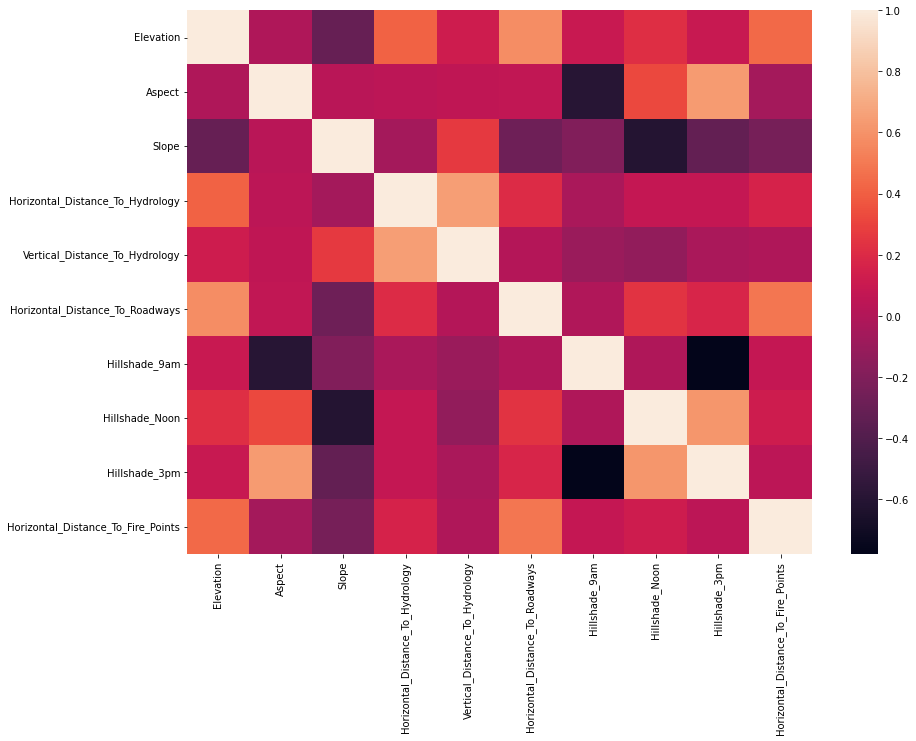

In [ ]:
# Print a heatmap representation of the correlation matrix between the numerica values
sns.heatmap(df_train[numeric_columns].corr());

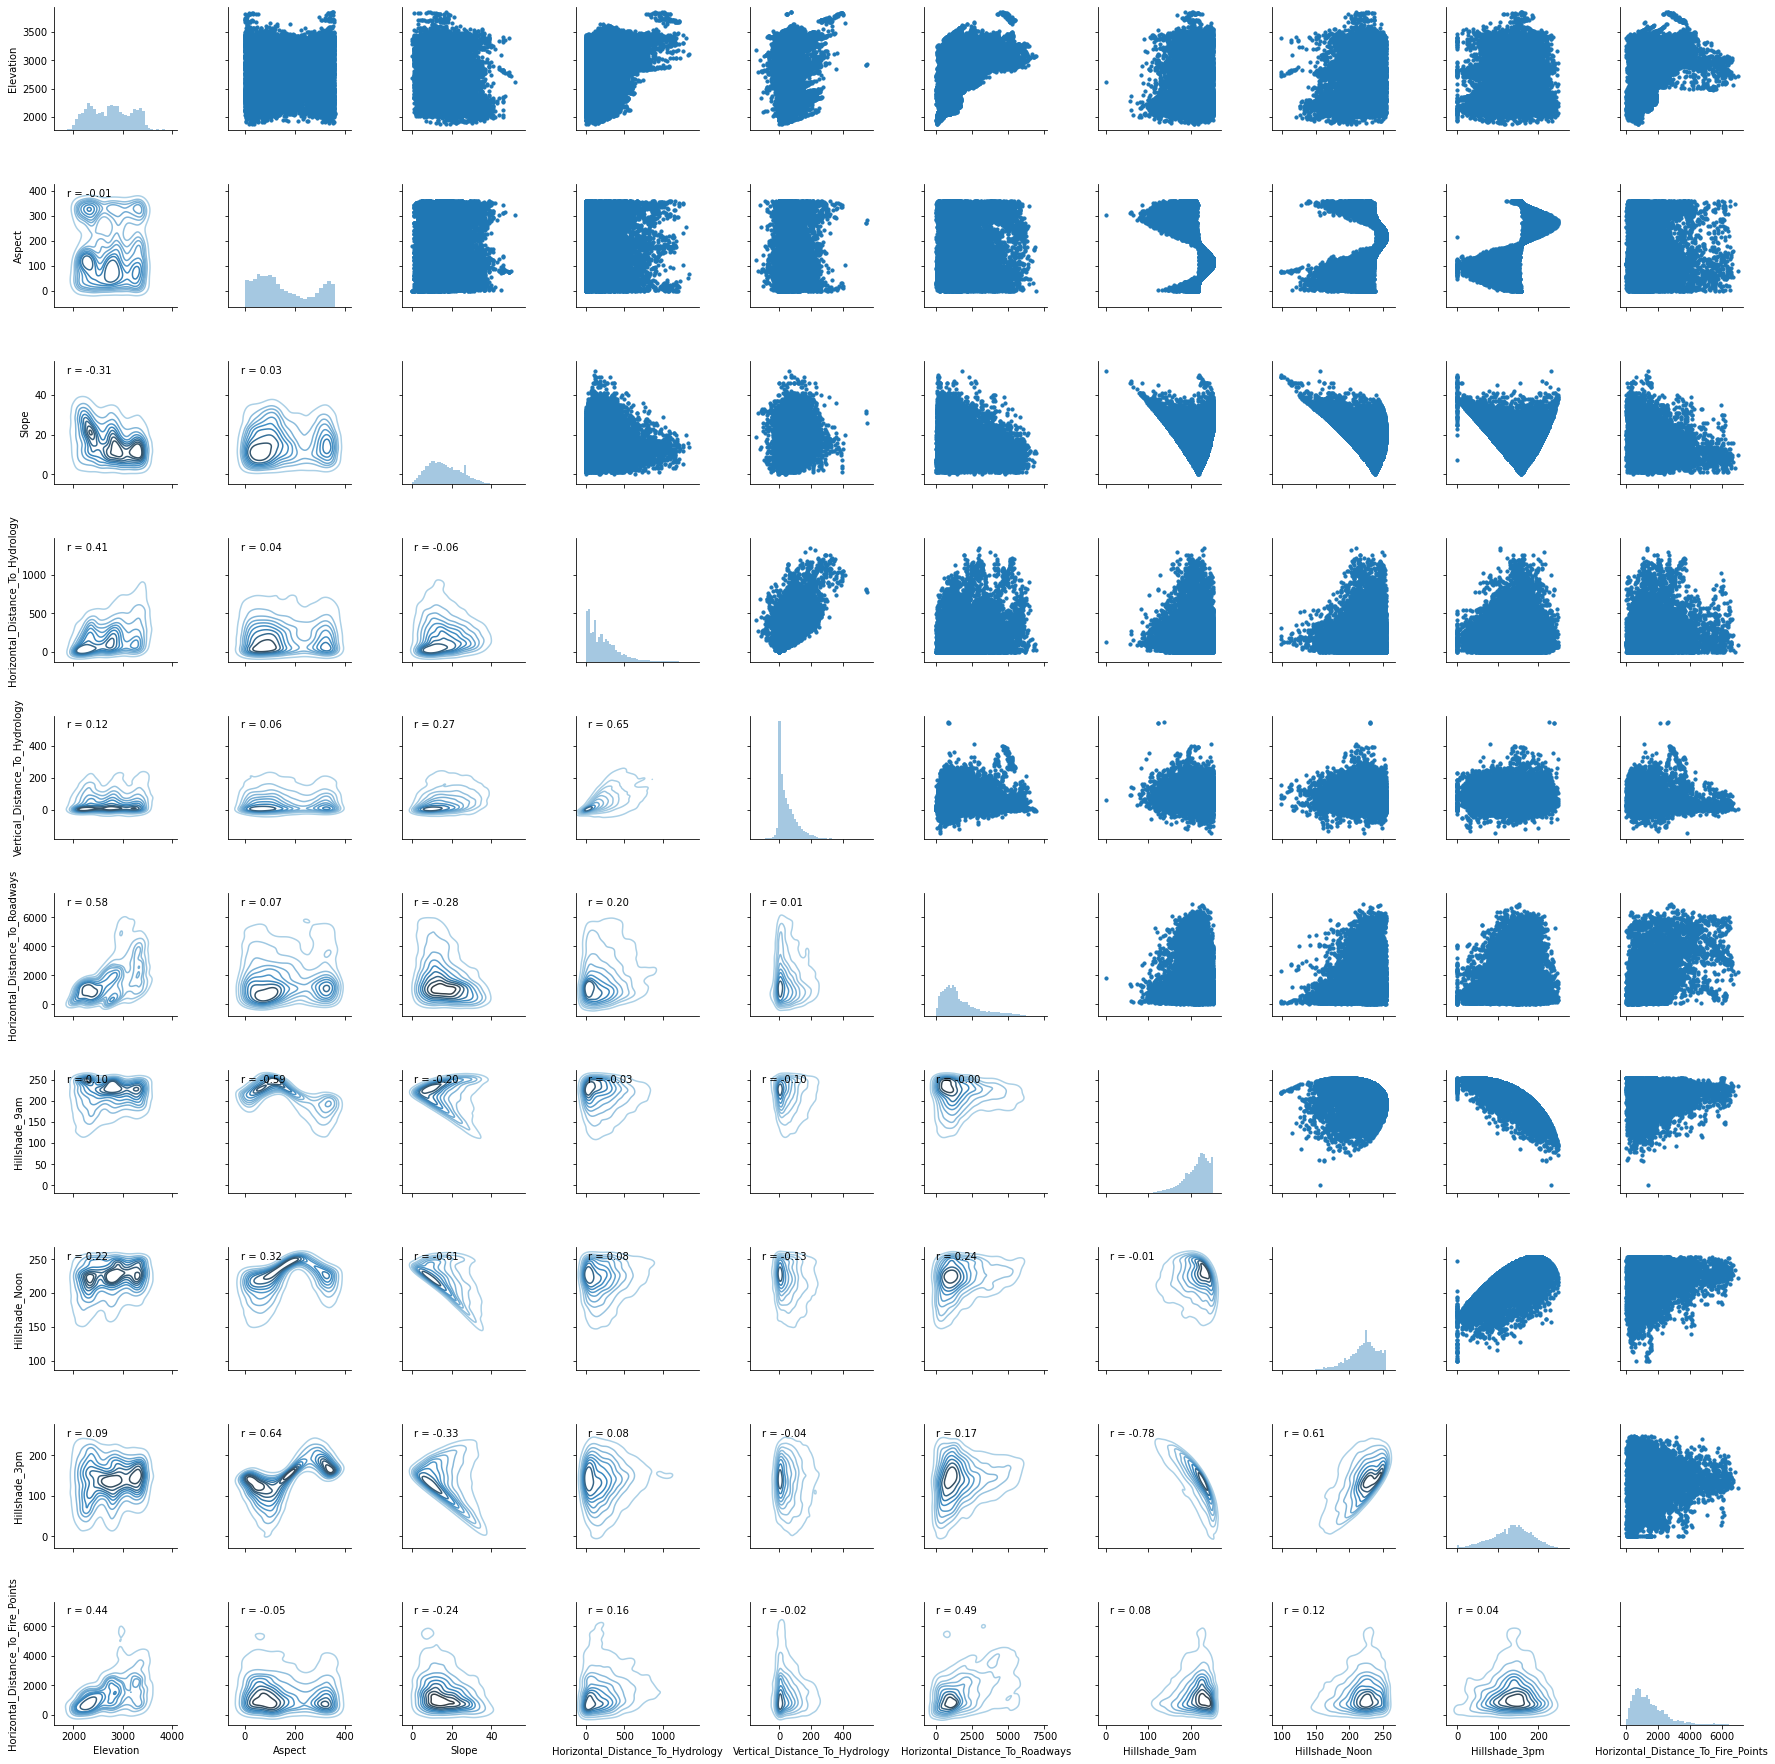

In [ ]:

def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .9), xycoords=ax.transAxes)

g = sns.PairGrid(df_train[numeric_columns], palette=["red"])
g.map_upper(plt.scatter, s=10)
g.map_diag(sns.distplot, kde=False)
g.map_lower(sns.kdeplot, cmap="Blues_d")
g.map_lower(corrfunc)

**Distributions:**

* Hillshade_9am and Hillshade_Noon has bi-modal and left-skewed distributions. 

* Horizontal_Distance_To_Firepoints, Horizontal_Distance_To_Roadways, Horizontal_Distance_To_Hydrology has bi-modal and right-skewed distributions.

* Elevation (height of a fantastic trees) resembles a uniform distribution.

* Slope, Vertical_Distance_To_Hydrology, Hillshade_3pm shows a symmetric and bi-modal distribution.


**Bi-modal**: A bimodal shape, has two peaks. This shape may show that the data has come from two different systems. If this shape occurs, perhaps the two sources should be separated and analyzed separately.



 **Left-skewed**: Left-skewed distributions are also called negatively-skewed distributions. That’s because there is a long tail in the negative direction on the number line. The mean is also to the left of the peak. A left-skewed, negative distribution will have the mean to the left of the median.


**Some obvious relationships between the continuous features:**

1. Elevation and shows positive trend with following variables:
    * Vertical_Distance_To_Hydrology
    * Horizontal_Distance_To_Roadways
    * Horizontal_Distance_To_Firepoints
    * Horizontal_Distance_To_Hydrology

2. As Aspect increases; Hillshade_Noon and Hillshade_3pm increases.

3. Slope has negative trend with:
    * Elevation
    * Horizontal_Distance_To_Roadways
    * Hillshade_9am, Hillshade_Noon and Hillshade_3pm
    * Horizontal_Distance_To_Firepoints

4. Horizontal_Distance_To_Hydrology has positive trend with:
    * Horizontal_Distance_To_Firepoints
    * Horizontal_Distance_To_Roadways
    * Vertical_Distance_To_Hydrology

5. Hillshade_3pm shows an strong negative relationship with Hillshade_9am  as well Vertical_Distance_To_Hydrology shows an strong positive with Horizontal_Distance_To_Hydrology this can indicate multicollinearity issues.

6. As Horizontal_Distance_To_Roadways increases,Horizontal_Distance_To_Firepoints increases and Slope decreases.

7. Hillshade_9am shows negative trend with Hillshade_3pm and Aspect, as Hillshade_9am increases Elevation increases.

8. Hillshade_Noon has positive trend with:
    * Elevation
    * Aspect
    * Horizontal_Distance_To_Roadways
    * Hillshade_3pm
    * Horizontal_Distance_To_Firepoints

9. Hillshade_3pm shows strong positive trend with Hillshade_Noon.

In [ ]:
corrMatrix = df_train[numeric_columns].corr()
correlatedVariables = pd.DataFrame()
for i in numeric_columns:
  for j in numeric_columns:
    if np.abs(corrMatrix.loc[i,j]) >= 0.5 and i!=j:
      correlatedVariables.loc[i,j] = corrMatrix.loc[i,j]
      print('The variable {} its highly correlated with {} with coefficient value of {}'.format(i,j,corrMatrix.loc[i,j]))

The variable Elevation its highly correlated with Horizontal_Distance_To_Roadways with coefficient value of 0.5786589907340067
The variable Aspect its highly correlated with Hillshade_9am with coefficient value of -0.5939974281313112
The variable Aspect its highly correlated with Hillshade_3pm with coefficient value of 0.635022364019874
The variable Slope its highly correlated with Hillshade_Noon with coefficient value of -0.6126128724172692
The variable Horizontal_Distance_To_Hydrology its highly correlated with Vertical_Distance_To_Hydrology with coefficient value of 0.6521424712357364
The variable Vertical_Distance_To_Hydrology its highly correlated with Horizontal_Distance_To_Hydrology with coefficient value of 0.6521424712357364
The variable Horizontal_Distance_To_Roadways its highly correlated with Elevation with coefficient value of 0.5786589907340067
The variable Hillshade_9am its highly correlated with Aspect with coefficient value of -0.5939974281313112
The variable Hillshade

### Some highly correlated features: ###



* hillshade noon - hillshade 3 pm
* hillsahde 3 pm - hillshade 9 am
* vertical distance to hydrology - horizontal distance to hydrology
* elevation - slope

Some high correlations between Hillshade variables, distance to hydrology. Makes sense since these variables seem interrelated.

## Visualize some highly correlated features with Cover_Type

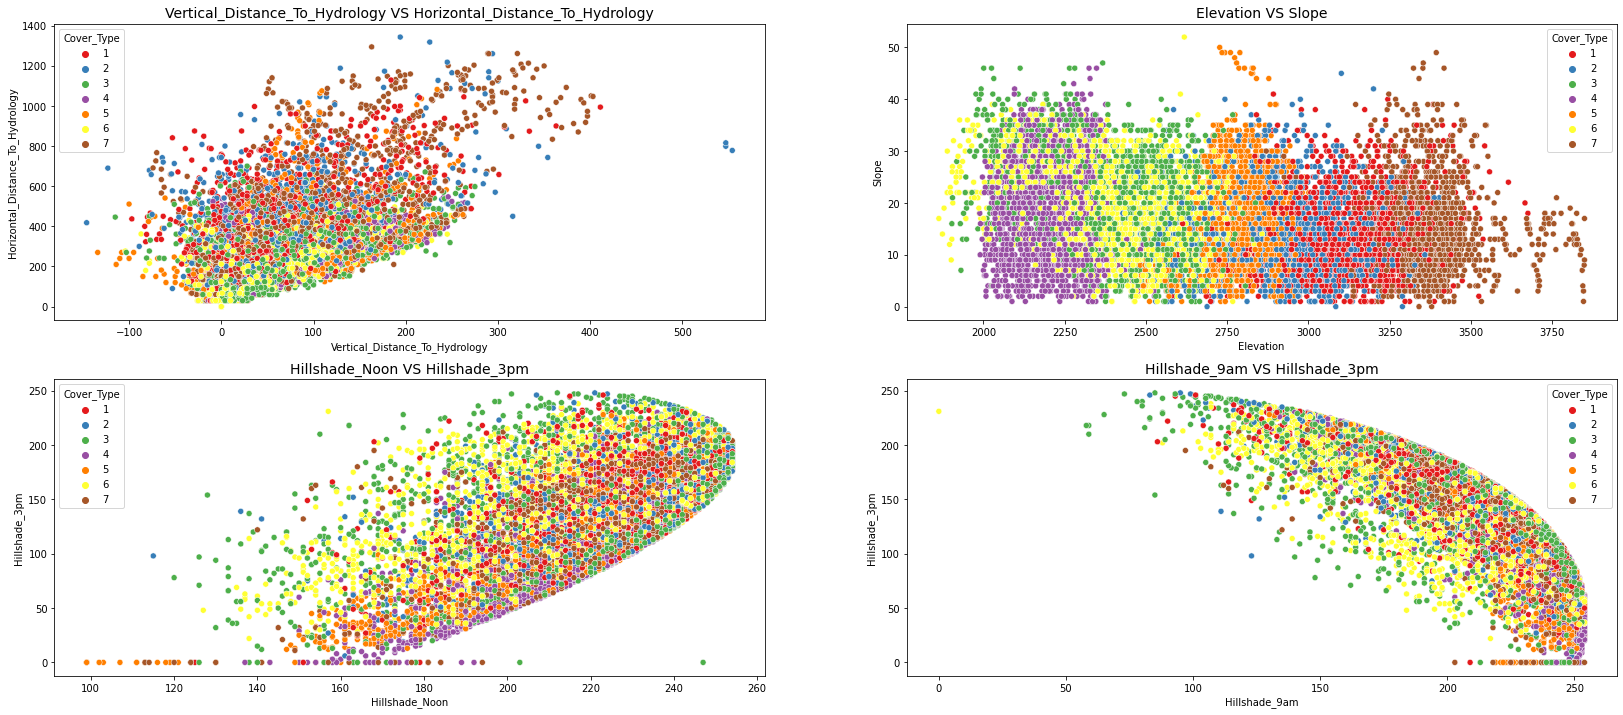

In [ ]:
figsize(28,12)

# plot the first subplot
plt.subplot(2,2,1)
sns.scatterplot(x="Vertical_Distance_To_Hydrology", y="Horizontal_Distance_To_Hydrology", 
                hue="Cover_Type", data=df_train, 
                legend="full", hue_norm=(0,8), palette="Set1")
plt.title("Vertical_Distance_To_Hydrology VS Horizontal_Distance_To_Hydrology", size=14)

# plot the second subplot
plt.subplot(2,2,2)
sns.scatterplot(x="Elevation", y="Slope", 
                hue="Cover_Type", data=df_train, 
                legend="full", hue_norm=(0,8), palette="Set1")
plt.title("Elevation VS Slope", size=14)


# plot the first subplot
plt.subplot(2,2,3)
sns.scatterplot(x="Hillshade_Noon", y="Hillshade_3pm", 
                hue="Cover_Type", data=df_train, 
                legend="full", hue_norm=(0,8), palette="Set1")
plt.title("Hillshade_Noon VS Hillshade_3pm", size=14)

# plot the second subplot
plt.subplot(2,2,4)
sns.scatterplot(x="Hillshade_9am", y="Hillshade_3pm", 
                hue="Cover_Type", data=df_train, 
                legend="full", hue_norm=(0,8), palette="Set1")
plt.title("Hillshade_9am VS Hillshade_3pm", size=14);

## Pearson Coefficients of all features

Text(0.5, 1.05, 'Pearson Correlation of All Features')

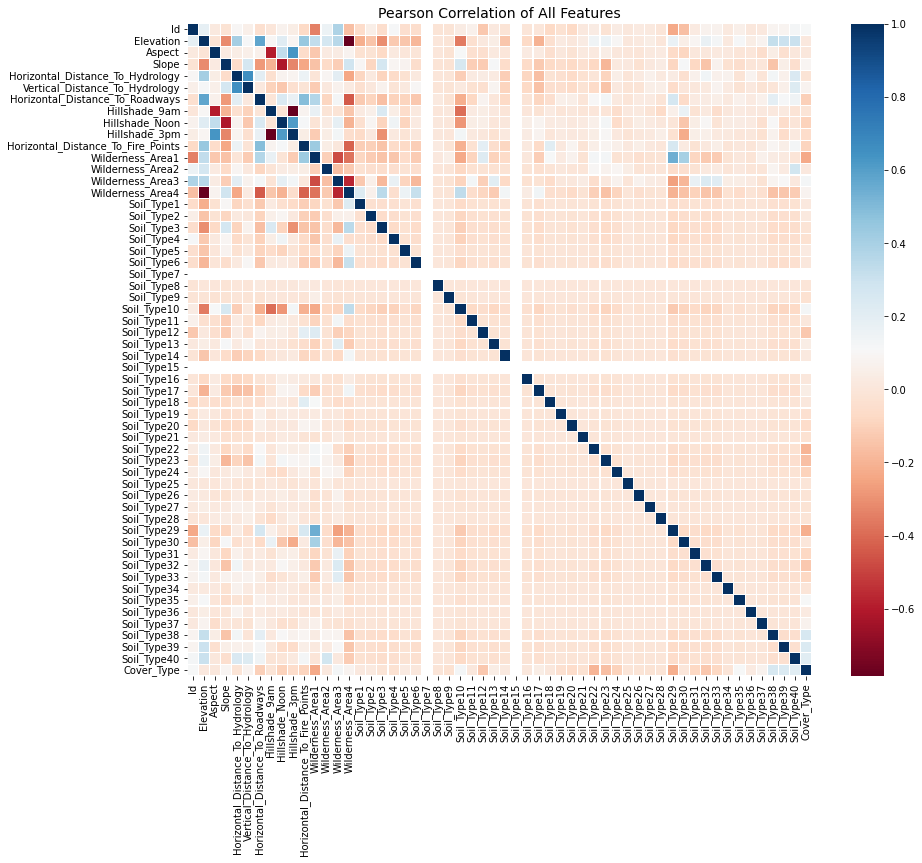

In [ ]:
plt.figure(figsize=(14,12))

# plot heatmap set the title
colormap = plt.cm.RdBu
sns.heatmap(df_train.corr(),linewidths=0.1,vmax=1.0, 
            square=False, cmap=colormap, linecolor='white', annot=False)
plt.title('Pearson Correlation of All Features', y=1.05, size=14);

In [ ]:
df_train[base_features].corr()['Cover_Type'].abs().sort_values(ascending = False)

Cover_Type                            1.000000
Soil_Type38                           0.257810
Soil_Type39                           0.240384
Wilderness_Area1                      0.230117
Soil_Type29                           0.218564
Soil_Type40                           0.205851
Soil_Type22                           0.195993
Soil_Type23                           0.158762
Soil_Type32                           0.132312
Soil_Type12                           0.129985
Soil_Type10                           0.128972
Wilderness_Area3                      0.122146
Soil_Type35                           0.114327
Horizontal_Distance_To_Roadways       0.105662
Soil_Type24                           0.100797
Hillshade_Noon                        0.098905
Horizontal_Distance_To_Fire_Points    0.089389
Slope                                 0.087722
Soil_Type31                           0.079882
Soil_Type33                           0.078955
Wilderness_Area4                      0.075774
Vertical_Dist

* It appears, according with the pearson coefficients none of the base features have significantly linear effect in determining the label cover type.

* One interesting finding though, Soil Type 7 and 15 correlation are none in the table, o it has no effect on determining the label Cover_Type.


# Return to base features after the EDA(Only if the EDA its use)

In [ ]:
df_train = df_train[base_features]

# **Baseline Results (No Feature Engineering)**

## Seperate labels from features in the training set

In [ ]:
df_baselinetrain = df_train.drop(['Cover_Type','Id'],axis=1)
labels_baselinetraining = df_train["Cover_Type"]

## Split training set as training and validation set


In [ ]:
X_baselinetrain, X_baselinevalid, y_baselinetrain, y_baselinevalid = train_test_split(df_baselinetrain, labels_baselinetraining, test_size=0.2, random_state=42)
print('Training Data Shape:', X_baselinetrain.shape)
print('Validation Data Shape:', X_baselinevalid.shape)

Training Data Shape: (12096, 54)
Validation Data Shape: (3024, 54)


#### Activating baseline

In [ ]:
X_train = X_baselinetrain
X_valid = X_baselinevalid
y_train = y_baselinetrain
y_valid = y_baselinevalid

## Compare Several Machine Learning Models
I am going to use (with default parameters for now) and without discussing specifics of the models:

1) K-Nearest Neighbors Classifier

2) Light Gradient Boosting Machine (LightGBM) Classifier

3) Random Forest Classifier

4) Extra Trees (Random Forests) Classifier

5) Extra Gradient Boosting (XGBoost) Classifier

and compare the results on accuracy score. Then I will select the best model with the highest accuracy score for use.

Since K-nearest neighbors classifier is using euclidian distance to cluster labels, I am going to use normalized training set for those.

In [ ]:
# create scaler
scaler = StandardScaler()

# apply normalization to training set and transform training set
X_train_scaled = scaler.fit_transform(X_train, y_train)

# transform validation set
X_valid_scaled = scaler.transform(X_valid)

## Build models

In [ ]:
# K-Nearest Neighbor Classifier
# create model apply fit_evaluate_model
knn_classifier = KNeighborsClassifier()
knn_accuracy = fit_evaluate_model(knn_classifier, X_train_scaled, y_train, X_valid_scaled, y_valid)
print("Number of correct predictions K-Nearest Neighbor Classifier that made out of all predictions are:", knn_accuracy)

# Light Gradient Boosting Machine (LightGBM) Classifier
# create model apply fit_evaluate_model
lgbm_classifier = LGBMClassifier()
lgbm_accuracy = fit_evaluate_model(lgbm_classifier, X_train_scaled, y_train, X_valid_scaled, y_valid)
print("Number of correct predictions for the Light Gradient Boosting Machine (LightGBM) Classifier that made out of all predictions are:", lgbm_accuracy)

# Random Forests Classifier
# create model apply fit_evaluate_model
rf_classifier = RandomForestClassifier()
rf_accuracy = fit_evaluate_model(rf_classifier, X_train, y_train, X_valid, y_valid)
print("Number of correct predictions for the Random Forests Classifier that made out of all predictions are:", rf_accuracy)

# Extra Trees (Random Forests) Classifier
# create model apply fit_evaluate_model
xrf_classifier = ExtraTreesClassifier()
xrf_accuracy = fit_evaluate_model(xrf_classifier, X_train, y_train, X_valid, y_valid)
print("Number of correct predictions for the Extra Trees (Random Forests) Classifier that made out of all predictions are:", xrf_accuracy)

# Extra Gradient Boosting (XGBoost) Classifier
# create model apply fit_evaluate_model 
xgb_classifier = XGBClassifier()
xgb_accuracy = fit_evaluate_model(xgb_classifier, X_train, y_train, X_valid, y_valid)
print("Number of correct predictions for the Extra Gradient Boosting (XGBoost) Classifier that made out of all predictions are:", xgb_accuracy)


Number of correct predictions K-Nearest Neighbor Classifier that made out of all predictions are: 0.7843915343915344
Number of correct predictions for the Light Gradient Boosting Machine (LightGBM) Classifier that made out of all predictions are: 0.8587962962962963
Number of correct predictions for the Random Forests Classifier that made out of all predictions are: 0.8664021164021164
Number of correct predictions for the Extra Trees (Random Forests) Classifier that made out of all predictions are: 0.8693783068783069
Number of correct predictions for the Extra Gradient Boosting (XGBoost) Classifier that made out of all predictions are: 0.7536375661375662


### Comparison of model performances

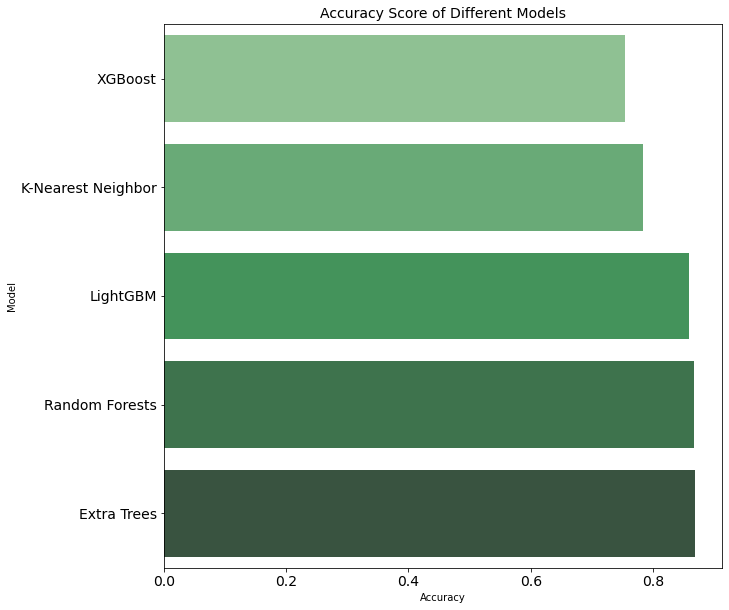

In [ ]:
# create dataframe of accuracy and model and sort values
performance_comparison = pd.DataFrame({"Model": ["K-Nearest Neighbor", "LightGBM", "Random Forests", "Extra Trees", "XGBoost"],
                                       "Accuracy": [knn_accuracy, lgbm_accuracy, rf_accuracy, xrf_accuracy, xgb_accuracy]})

performance_comparison = performance_comparison.sort_values(by="Accuracy", ascending=True)

# set the plot
plt.figure(figsize=(10,10))
ax = sns.barplot(x="Accuracy", y="Model", data=performance_comparison, palette="Greens_d")

# set title arrange labels
plt.yticks(size = 14)
plt.xticks(size = 14)
plt.title("Accuracy Score of Different Models", size=14);

In [ ]:
# Baseline submission with Extra Trees (Random Forests) Classifier

#Removing the previous baseline submision
if path.exists('/content/gdrive/MyDrive/Forest Cover Type Prediction/baseline_submission.csv') == True:
  os.remove('/content/gdrive/MyDrive/Forest Cover Type Prediction/baseline_submission.csv')

pred_df_test = xrf_classifier.predict(df_test[df_train.columns[:-1]])
output = pd.DataFrame({'Id': df_test['Id'],
                       'Cover_Type': pred_df_test})
output.head()
output.to_csv('baseline_submission.csv', index=False)

This baseline submision score 0.74071 in the Kaggle Competition



Although it is known that gradient boosting algorithm outperforms others by loss, as plotted below heatmap, extreme (extra) random forests outperformed other algorithms with accuracy performance metric in this case. The reason might be, I did not focus on tuning the parameters of the each algorithm and used defaults values instead.

# **Feature Engineering & Selection**

Note: Since the test data is much larger than the training data, and performs differently, I'm not going to remove any predictors. Instead I'm going to focus on creating new ones that highlight similarities in the data. I also want to combine elevation with other predictors.


Due to the characteristics of some features, it would make sense to introduce new ones and observe their implication in the models. This model according to the literature and the research carried out is summarized in
 add new features and in some cases customize certain models.


In [ ]:

def transformfeatureI(df, B1=1, B2=1, B3=1, B4=1, B5=1):
  # remove unuseful features
  df = df.drop([ 'Soil_Type7', 'Soil_Type15'], axis=1)

  cols = list(df.columns)
  df['Hillshade'] = df['Hillshade_9am'] + df['Hillshade_3pm'] + df['Hillshade_Noon']


  
  if B1!=0:
    #Elevations transformations 
    df['binned_elev'] = [math.floor(v/50.0) for v in df['Elevation']]
    df['Elevation_Fire_Points'] = df['Elevation']+df['Horizontal_Distance_To_Fire_Points']
    df['Road_Fire'] = df['Horizontal_Distance_To_Roadways'] + df['Horizontal_Distance_To_Fire_Points']
    df['Road-Fire'] = df['Horizontal_Distance_To_Roadways'] - df['Horizontal_Distance_To_Fire_Points']
    df['Ele_Road_Fire_Hydro'] = df['Elevation'] + df['Horizontal_Distance_To_Roadways']  + df['Horizontal_Distance_To_Fire_Points'] + df['Horizontal_Distance_To_Hydrology']
    df['Mean_Elevation_Vertical_Distance_Hydrology'] = (df['Elevation'] + 
                                                                      df['Vertical_Distance_To_Hydrology'])/2
    df['Ele-Road'] = df['Elevation'] + df['Horizontal_Distance_To_Roadways']
    df['Ele_Road'] = df['Elevation'] - df['Horizontal_Distance_To_Roadways']
    df['Ele-Fire'] = df['Elevation'] + df['Horizontal_Distance_To_Fire_Points']
    df['Ele_Fire'] = df['Elevation'] - df['Horizontal_Distance_To_Fire_Points']
    df['Ele_Hillshade'] = df['Elevation'] - df['Hillshade']
    df['Ele-Hillshade'] = df['Elevation'] + df['Hillshade']
  
  if B2!=0:
    #None elevation combos:
    df['Soil_W1'] = df['Soil_Type29'] + df['Wilderness_Area1']
    df['Soil_W4'] = df['Wilderness_Area4'] + df['Soil_Type3']
    df['Hydrology_Total'] = abs(df["Horizontal_Distance_To_Hydrology"])+abs(df['Vertical_Distance_To_Hydrology'])

  if B3!=0:
    #Summary metrics
    df["mean"] = df[cols].mean(axis=1)
    df["min"] = df[cols].min(axis=1)
    df["max"] = df[cols].max(axis=1)
    df["std"] = df[cols].std(axis=1)

  if B4!=0:
    #Other
    
    df['Euclidian_Distance_To_Hydrology'] = (df['Horizontal_Distance_To_Hydrology']**2 + 
                                                            df['Vertical_Distance_To_Hydrology']**2)**0.5
    df['Mean_Distance_Hydrology_Firepoints'] = (df['Horizontal_Distance_To_Hydrology'] + 
                                                              df['Horizontal_Distance_To_Fire_Points'])/2
    df['Mean_Distance_Hydrology_Roadways'] = (df['Horizontal_Distance_To_Hydrology'] + 
                                                            df['Horizontal_Distance_To_Roadways'])/2
    df['Mean_Distance_Firepoints_Roadways'] = (df['Horizontal_Distance_To_Fire_Points'] + 
                                                              df['Horizontal_Distance_To_Roadways'])/2

  if B5!=0:
    # Summed features pointed out by @craigmthomas (https://www.kaggle.com/c/tabular-playground-series-dec-2021/discussion/292823)
    soil_features = [x for x in df.columns if x.startswith("Soil_Type")]
    wilderness_features = [x for x in df.columns if x.startswith("Wilderness_Area")]

    df["soil_type_count"] = df[soil_features].sum(axis=1)

    df["wilderness_area_count"] = df[wilderness_features].sum(axis=1)

    df['binned_elevation'] = [math.floor(v/50.0) for v in df['Elevation']]
    df['Horizontal_Distance_To_Roadways_Log'] = [math.log(v+1) for v in df['Horizontal_Distance_To_Roadways']]

    df['Soil_Type12_32'] = df['Soil_Type32'] + df['Soil_Type12']
    df['Soil_Type23_22_32_33'] = df['Soil_Type23'] + df['Soil_Type22'] + df['Soil_Type32'] + df['Soil_Type33']
    

  return df                                                            
  
  

In [ ]:
# Extra Trees (Random Forests) Classifier
xrf_classifier = ExtraTreesClassifier()

df_train_B1 = transformfeatureI(df_train.drop(['Id','Cover_Type'],axis=1), 1, 0, 0, 0, 0)
X_train, X_valid, y_train, y_valid = train_test_split(df_train_B1, df_train["Cover_Type"], test_size=0.2, random_state=42)
# create model apply fit_evaluate_model
xrf_accuracy = fit_evaluate_model(xrf_classifier, X_train, y_train, X_valid, y_valid)
print("B1 :Number of correct predictions for the Extra Trees (Random Forests) Classifier that made out of all predictions are:", xrf_accuracy)

df_train_B12 = transformfeatureI(df_train.drop(['Id','Cover_Type'],axis=1), 1, 1, 0, 0, 0)
X_train, X_valid, y_train, y_valid = train_test_split(df_train_B12, df_train["Cover_Type"], test_size=0.2, random_state=42)
# create model apply fit_evaluate_model
xrf_accuracy = fit_evaluate_model(xrf_classifier, X_train, y_train, X_valid, y_valid)
print("B1-2 :Number of correct predictions for the Extra Trees (Random Forests) Classifier that made out of all predictions are:", xrf_accuracy)

df_train_B13 = transformfeatureI(df_train.drop(['Id','Cover_Type'],axis=1), 1, 1, 1,  0, 0)
X_train, X_valid, y_train, y_valid = train_test_split(df_train_B13, df_train["Cover_Type"], test_size=0.2, random_state=42)
# create model apply fit_evaluate_model
xrf_accuracy = fit_evaluate_model(xrf_classifier, X_train, y_train, X_valid, y_valid)
print("B1-3 :Number of correct predictions for the Extra Trees (Random Forests) Classifier that made out of all predictions are:", xrf_accuracy)


df_train_B14 = transformfeatureI(df_train.drop(['Id','Cover_Type'],axis=1), 1, 1, 1,  1, 0)
X_train, X_valid, y_train, y_valid = train_test_split(df_train_B14, df_train["Cover_Type"], test_size=0.2, random_state=42)
# create model apply fit_evaluate_model
xrf_accuracy = fit_evaluate_model(xrf_classifier, X_train, y_train, X_valid, y_valid)
print("B1-4 :Number of correct predictions for the Extra Trees (Random Forests) Classifier that made out of all predictions are:", xrf_accuracy)

df_train_All = transformfeatureI(df_train.drop(['Id','Cover_Type'],axis=1))
X_train, X_valid, y_train, y_valid = train_test_split(df_train_All, df_train["Cover_Type"], test_size=0.2, random_state=42)
# create model apply fit_evaluate_model
xrf_accuracy = fit_evaluate_model(xrf_classifier, X_train, y_train, X_valid, y_valid)
print("All tranformations :Number of correct predictions for the Extra Trees (Random Forests) Classifier that made out of all predictions are:", xrf_accuracy)

B1 :Number of correct predictions for the Extra Trees (Random Forests) Classifier that made out of all predictions are: 0.8984788359788359
B1-2 :Number of correct predictions for the Extra Trees (Random Forests) Classifier that made out of all predictions are: 0.9004629629629629
B1-3 :Number of correct predictions for the Extra Trees (Random Forests) Classifier that made out of all predictions are: 0.9001322751322751
B1-4 :Number of correct predictions for the Extra Trees (Random Forests) Classifier that made out of all predictions are: 0.9021164021164021
All tranformations :Number of correct predictions for the Extra Trees (Random Forests) Classifier that made out of all predictions are: 0.9007936507936508


 Adding a few at a time and then checked the results on the validation data we can see especially for the extra trees model, accuracy kept increasing as predictors were added. So lets take this information and tune the parameters.

# **Perform Hyperparameter Tuning on the Bests Models** 

Now, I am going to perform hyperparameter tuning on the bests models Extra Random Forests classifier and Light Gradient Boosting Machine classifier trying to improve accuracy of the model. Searching and setting the best and optimal set of parameters for a machine learning model its defined as hyperparameter tuning

I am going to search for the best set of parameters with random search and cross validation.

In random search, set of ML model's parameters are defined in a range and inputted to RandomizedSearchCV. This algorithm randomly selects some combination of the parameters and compares the defined score (accuracy, for this problem) with iterations. Random search runtime and iterations can be controlled with the parameter n_iter. This is in contrast to grid search iterations of every single combination of the given parameters. With intuition, one can say that, grid search requires more run-time than random search if a small number of n_iterations is defined. Generally, random search is better when there is a limited knowledge and of the best model hyperparameters and less time.


### Extra Random Forests classifier



In [ ]:
df_train_All = transformfeatureI(df_train.drop(['Id','Cover_Type'],axis=1))
X_train, X_valid, y_train, y_valid = train_test_split(df_train_All, df_train["Cover_Type"], test_size=0.2, random_state=42)

# The number of trees in the forest algorithm, default value is 10.
n_estimators = [50, 100, 300, 500, 1000]

# The minimum number of samples required to split an internal node, default value is 2.
min_samples_split = [2, 3, 5, 7, 9]

# The minimum number of samples required to be at a leaf node, default value is 1.
min_samples_leaf = [1, 2, 4, 6, 8]

# The number of features to consider when looking for the best split, default value is auto.
max_features = ['auto', 'sqrt', 'log2', None] 

# Define the grid of hyperparameters to search
hyperparameter_grid = {'n_estimators': n_estimators,
                       'min_samples_leaf': min_samples_leaf,
                       'min_samples_split': min_samples_split,
                       'max_features': max_features}

In [ ]:
# create model 
xrf_classifier = ExtraTreesClassifier(random_state=42)

# create Randomized search object


Rand_extrf = RandomizedSearchCV(estimator=xrf_classifier,
                               param_distributions=hyperparameter_grid,
                               cv=5, n_iter=10, 
                               scoring = 'accuracy',
                               n_jobs = -1, verbose = 1, 
                               return_train_score = True, 
                               random_state=42)

# Fit on the all training data using random search object (8 min 34 s run)
Rand_extrf.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=ExtraTreesClassifier(random_state=42),
                   n_jobs=-1,
                   param_distributions={'max_features': ['auto', 'sqrt', 'log2',
                                                         None],
                                        'min_samples_leaf': [1, 2, 4, 6, 8],
                                        'min_samples_split': [2, 3, 5, 7, 9],
                                        'n_estimators': [50, 100, 300, 500,
                                                         1000]},
                   random_state=42, return_train_score=True, scoring='accuracy',
                   verbose=1)

In [ ]:
print("Best ExtraTreesClassifier Params:", Rand_extrf.best_params_)

Best ExtraTreesClassifier Params: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None}


In [ ]:
Rand_ExtraTree_optimal_model = ExtraTreesClassifier(n_estimators=300, 
                                                     max_features=None, 
                                                     min_samples_leaf=1, 
                                                     min_samples_split=2,
                                                     random_state=42)
# Fit te optimal model
Rand_ExtraTree_optimal_model.fit(X_train, y_train)

ExtraTreesClassifier(max_features=None, n_estimators=300, random_state=42)

In [ ]:
# Submission with the optimal Extra Trees (Random Forests) Classifier after randomsearch

#Removing the previous randsearch optimal submision
if path.exists('/content/gdrive/MyDrive/Forest Cover Type Prediction') == True:
  if path.exists('/content/gdrive/MyDrive/Forest Cover Type Prediction/ExtraTreeRand_submission.csv') == True:
    os.remove('/content/gdrive/MyDrive/Forest Cover Type Prediction/ExtraTreeRand_submission.csv')


X_test = transformfeatureI(df_test.drop('Id',axis=1))
pred_df_test = Rand_ExtraTree_optimal_model.predict(X_test)
output = pd.DataFrame({'Id': df_test['Id'],
                       'Cover_Type': pred_df_test})
output.head()
output.to_csv('ExtraTreeRand_submission.csv', index=False)

*0.77962* 

### Light Gradient Boosting Machine classifier 

In [ ]:
df_train_All = transformfeatureI(df_train.drop(['Id','Cover_Type'],axis=1))
X_train, X_valid, y_train, y_valid = train_test_split(df_train_All, df_train["Cover_Type"], test_size=0.2, random_state=42)

# create scaler
scaler = StandardScaler()

# apply normalization to training set and transform training set
X_train_scaled = scaler.fit_transform(X_train, y_train)

# transform validation set
X_valid_scaled = scaler.transform(X_valid)

# The number  Maximum tree leaves for base learners.
num_leaves = [7, 15, 31, 63]

# The number of maximum tree depth for base learners, <=0 means no limit.
max_depth = [3, 4, 5, -1] 

# Boosting learning rate.
learning_rate= [0.2, 0.3, 0.5, 0.6]

# Number of boosted trees to fit.
n_estimators2=[200]

# Define the grid of hyperparameters to search
hyperparameter_grid2 = {'n_estimators': n_estimators2,
                       'num_leaves': num_leaves,
                       'max_depth': max_depth,
                       'learning_rate': learning_rate}

In [ ]:
# Light Gradient Boosting Machine (LightGBM) Classifier
# create model apply fit_evaluate_model
lgbm_classifier = LGBMClassifier(random_state=42)

# create Randomized search object
Rand_lgbm = RandomizedSearchCV(estimator=lgbm_classifier,
                               param_distributions=hyperparameter_grid2,
                               cv=5, n_iter=10, 
                               scoring = 'accuracy',
                               n_jobs = -1, verbose = 1, 
                               return_train_score = True, 
                               random_state=42)

# Fit on the all training data using random search object
Rand_lgbm.fit(X_train_scaled, y_train, eval_set=(X_valid_scaled, y_valid))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[1]	valid_0's multi_logloss: 1.11225
[2]	valid_0's multi_logloss: 0.889018
[3]	valid_0's multi_logloss: 0.76282
[4]	valid_0's multi_logloss: 0.684646
[5]	valid_0's multi_logloss: 0.632098
[6]	valid_0's multi_logloss: 0.593274
[7]	valid_0's multi_logloss: 0.563424
[8]	valid_0's multi_logloss: 0.542129
[9]	valid_0's multi_logloss: 0.523953
[10]	valid_0's multi_logloss: 0.50754
[11]	valid_0's multi_logloss: 0.493344
[12]	valid_0's multi_logloss: 0.479788
[13]	valid_0's multi_logloss: 0.472193
[14]	valid_0's multi_logloss: 0.466067
[15]	valid_0's multi_logloss: 0.456746
[16]	valid_0's multi_logloss: 0.449938
[17]	valid_0's multi_logloss: 0.441315
[18]	valid_0's multi_logloss: 0.433333
[19]	valid_0's multi_logloss: 0.425478
[20]	valid_0's multi_logloss: 0.421021
[21]	valid_0's multi_logloss: 0.415029
[22]	valid_0's multi_logloss: 0.413981
[23]	valid_0's multi_logloss: 0.407941
[24]	valid_0's multi_logloss: 0.402591
[25]	valid_0's 

RandomizedSearchCV(cv=5, estimator=LGBMClassifier(random_state=42), n_jobs=-1,
                   param_distributions={'learning_rate': [0.2, 0.3, 0.5, 0.6],
                                        'max_depth': [3, 4, 5, -1],
                                        'n_estimators': [200],
                                        'num_leaves': [7, 15, 31, 63]},
                   random_state=42, return_train_score=True, scoring='accuracy',
                   verbose=1)

In [ ]:
print("Best LGBMClassifier Params:", Rand_lgbm.best_params_)


Best LGBMClassifier Params: {'num_leaves': 31, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.6}


In [ ]:
Rand_LGBM_optimal_model = LGBMClassifier(n_estimators=200, 
                                                     num_leaves=31, 
                                                     max_depth=5, 
                                                     learning_rate= 0.6,
                                                     random_state=42)
# Fit te optimal model
Rand_LGBM_optimal_model.fit(X_train, y_train)

LGBMClassifier(learning_rate=0.6, max_depth=5, n_estimators=200,
               random_state=42)

In [ ]:
# Submission with the optimal  LGBMClassifier after the randomsearch

#Removing the previous randsearch optimal submision
if path.exists('/content/gdrive/MyDrive/Forest Cover Type Prediction') == True:
  if path.exists('/content/gdrive/MyDrive/Forest Cover Type Prediction/LGBMRand_submission.csv') == True:
    os.remove('/content/gdrive/MyDrive/Forest Cover Type Prediction/LGBMRand_submission.csv')

X_test = transformfeatureI(df_test.drop('Id',axis=1))
pred_df_test = Rand_LGBM_optimal_model.predict(X_test)
output = pd.DataFrame({'Id': df_test['Id'],
                       'Cover_Type': pred_df_test})
output.head()
output.to_csv('LGBMRand_submission.csv', index=False)

*0.75768*

# With the current workflow, and selection of features, extra random forests model and parameters are the best option for succesfully detected more than 77 percent of the trees correctly!
(Previous accuracy score in the baseline model 74% with random forests) 